# CS6910 Assignment 3 - Sujay and Avyay

In [ ]:
!pip install wordcloud
!pip install colour

In [13]:
## Installing font for Hindi for matplotlib ##
!apt-get install -y fonts-lohit-deva
!fc-list :lang=hi family

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-lohit-deva
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 78.9 kB of archives.
After this operation, 198 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-lohit-deva all 2.95.4-4 [78.9 kB]
Fetched 78.9 kB in 0s (358 kB/s)
Selecting previously unselected package fonts-lohit-deva.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-lohit-deva_2.95.4-4_all.deb ...
Unpacking fonts-lohit-deva (2.95.4-4) ...
Setting up fonts-lohit-deva (2.95.4-4) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Lohit Devanagari


In [1]:
import os
import random
import time
import wandb
import re, string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from colour import Color
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Data

In [ ]:
## Download the dataset ##
import requests
import tarfile

def download_data(save_path):

    data_url = r"https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

    r = requests.get(data_url, allow_redirects=True)
    tar_path = "data_assignment3.tar"

    if r.status_code == 200:
        with open(tar_path, 'wb') as f:
            f.write(r.content)

    tar_file = tarfile.open(tar_path)
    tar_file.extractall(save_path)
    tar_file.close()


# downloading and extracting the data to drive
# uncomment the line below if downloading data for the 1st time
# download_data("/content/drive/MyDrive/DakshinaDataset")

# Data Preprocessing

In [3]:
# Files with English to Devanagari (Hindi) translation word by word
# Punctutations have already been cleaned from this file

def get_data_files(language):
    """ Function fo read data
    """

    ## REPLACE THIS PATH UPTO dakshina_dataset_v1.0 with your own dataset path ##
    template = "/content/drive/MyDrive/Assignment_3/hi.translit.sampled.{}.tsv"

    train_tsv = template.format("dev")
    val_tsv = template.format("dev")
    test_tsv = template.format("test")

    return train_tsv, val_tsv, test_tsv

## Utility functions for preprocessing data ##

def add_start_end_tokens(df, cols, sos="\t", eos="\n"):
    """ Adds EOS and SOS tokens to data
    """
    def add_tokens(s):
        # \t = starting token
        # \n = ending token
        return sos + str(s) + eos

    for col in cols:
        df[col] = df[col].apply(add_tokens)

def tokenize(lang, tokenizer=None):
    """ Uses tf.keras tokenizer to tokenize the data/words into characters
    """

    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(lang)

        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
                                                            padding='post')

    else:
        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
                                                            padding='post')

    return lang_tensor, tokenizer

def preprocess_data(fpath, input_lang_tokenizer=None, targ_lang_tokenizer=None):
    """ Reads, tokenizes and adds SOS/EOS tokens to data based on above functions
    """

    df = pd.read_csv(fpath, sep="\t", header=None)

    # adding start and end tokens to know when to stop predicting
    add_start_end_tokens(df, [0,1])

    input_lang_tensor, input_tokenizer = tokenize(df[1].astype(str).tolist(),
                                                    tokenizer=input_lang_tokenizer)

    targ_lang_tensor, targ_tokenizer = tokenize(df[0].astype(str).tolist(),
                                                    tokenizer=targ_lang_tokenizer)

    dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    dataset = dataset.shuffle(len(dataset))

    return dataset, input_tokenizer, targ_tokenizer

# Model Building

In [4]:
## Utility functions ##
def get_layer(name, units, dropout, return_state=False, return_sequences=False):

    if name=="rnn":
        return layers.SimpleRNN(units=units, dropout=dropout,
                                return_state=return_state,
                                return_sequences=return_sequences)

    if name=="gru":
        return layers.GRU(units=units, dropout=dropout,
                          return_state=return_state,
                          return_sequences=return_sequences)

    if name=="lstm":
        return layers.LSTM(units=units, dropout=dropout,
                           return_state=return_state,
                           return_sequences=return_sequences)

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, enc_state, enc_out):

    enc_state = tf.concat(enc_state, 1)
    enc_state = tf.expand_dims(enc_state, 1)

    score = self.V(tf.nn.tanh(self.W1(enc_state) + self.W2(enc_out)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * enc_out
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


class Encoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, encoder_vocab_size, embedding_dim, dropout):
        super(Encoder, self).__init__()
        self.layer_type = layer_type
        self.n_layers = n_layers
        self.units = units
        self.dropout = dropout
        self.embedding = tf.keras.layers.Embedding(encoder_vocab_size, embedding_dim)
        self.create_rnn_layers()

    def call(self, x, hidden):
        x = self.embedding(x)
        outputs=x
        # x = self.rnn_layers[0](x, initial_state=hidden)

        # for layer in self.rnn_layers[1:]:
        #     x = layer(x)

        # output, state = x[0], x[1:]
        print("LSTM layer:", self.layer_type)
        output = self.rnn_layers[0](outputs, initial_state=hidden)
        print("Returned:", type(output), output)

        if (self.layer_type=='lstm'):
            outputs, h, c = self.rnn_layers[0](outputs, initial_state=hidden)
            state = [h, c]
        else:
            outputs, h = self.rnn_layers[0](outputs, initial_state=hidden)
            state = [h]

        # Remaining LSTM layers just take outputs from previous layer
        for layer in self.rnn_layers[1:]:
            if (self.layer_type=='lstm'):
               outputs, h, c = layer(outputs)
               state = [h, c]  # update state if needed
            else:
               outputs, h = layer(outputs)
               state = [h]

        return outputs, state

    def create_rnn_layers(self):
        self.rnn_layers = []

        for i in range(self.n_layers):
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                                return_sequences=True,
                                                return_state=True))


    def initialize_hidden_state(self, batch_size):

        if self.layer_type != "lstm":
            return [tf.zeros((batch_size, self.units))]
        else:
            return [tf.zeros((batch_size, self.units))]*2

class Decoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, decoder_vocab_size, embedding_dim, dropout, attention=False):
        super(Decoder, self).__init__()

        self.layer_type = layer_type
        self.n_layers = n_layers
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.embedding_layer = layers.Embedding(input_dim=decoder_vocab_size,
                                                output_dim=embedding_dim)

        self.dense = layers.Dense(decoder_vocab_size, activation="softmax")
        self.flatten = layers.Flatten()
        if self.attention:
            self.attention_layer = BahdanauAttention(self.units)
        self.create_rnn_layers()

    def call(self, x, hidden, enc_out=None):

        # x = self.embedding_layer(x)

        # if self.attention:
        #     context_vector, attention_weights = self.attention_layer(hidden, enc_out)
        #     x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        # else:
        #     attention_weights = None

        # x = self.rnn_layers[0](x, initial_state=hidden)

        # for layer in self.rnn_layers[1:]:
        #     x = layer(x)

        # output, state = x[0], x[1:]

        # output = self.dense(self.flatten(output))

        x = self.embedding_layer(x)

        if self.attention:
            context_vector, attention_weights = self.attention_layer(hidden, enc_out)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        else:
            attention_weights = None

        # First LSTM layer gets the initial hidden state
        if (self.layer_type=='lstm'):
            x, h, c = self.rnn_layers[0](x, initial_state=hidden)
            state = [h, c]
        else:
            x, h = self.rnn_layers[0](x, initial_state=hidden)
            state = [h]

        # Subsequent layers use only the output of the previous layer
        for layer in self.rnn_layers[1:]:
            if (self.layer_type=='lstm'):
                x, h, c = layer(x)
                state = [h, c]  # Update state if you want final output from last LSTM
            else:
                x, h = layer(x)
                state = [h]

        output = self.dense(self.flatten(x))

        return output, state, attention_weights

    def create_rnn_layers(self):
        self.rnn_layers = []

        for i in range(self.n_layers - 1):
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                                return_sequences=True,
                                                return_state=True))

        self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                            return_sequences=False,
                                            return_state=True))

In [5]:
class BeamSearch():
    def __init__(self, model, k):
        self.k = k
        self.model = model
        self.acc = tf.keras.metrics.Accuracy()

    def sample_beam_search(self, probs):

        m, n = probs.shape
        output_sequences = [[[], 0.0]]

        for row in probs:
            beams = []

            for tup in output_sequences:
                seq, score = tup
                for j in range(n):
                    new_beam = [seq + [j], score - tf.math.log(row[j])]
                    beams.append(new_beam)

            output_sequences = sorted(beams, key=lambda x: x[1])[:self.k]

        tensors, scores = list(zip(*output_sequences))
        tensors = list(map(lambda x: tf.expand_dims(tf.constant(x),0), tensors))

        return tf.concat(tensors, 0), scores

    def beam_accuracy(self, input, target):
        accs = []

        for i in range(self.k):
            self.acc.reset_states()
            self.acc.update_state(target, input[i, :])
            accs.append(self.acc.result())

        return max(accs)

    def step(self, input, target, enc_state):

        batch_acc = 0
        sequences = []

        enc_out, enc_state = self.model.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*self.model.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        for i in range(target.shape[0]):

            possibilities, scores = self.sample_beam_search(sequences[i, :, :])
            batch_acc += self.beam_accuracy(possibilities, target[i, 1:])

        batch_acc = batch_acc / target.shape[0]

        return 0, batch_acc

    def evaluate(self, test_dataset, batch_size=None, upto=5, use_wandb=False):

        if batch_size is not None:
            self.model.batch_size = batch_size
            test_dataset = test_dataset.batch(batch_size)
        else:
            self.model.batch_size = 1

        test_acc = 0
        enc_state = self.model.encoder.initialize_hidden_state(self.model.batch_size)

        for batch, (input, target) in enumerate(test_dataset.take(upto)):

           _, acc = self.step(input, target, enc_state)
           test_acc += acc

        if use_wandb:
            wandb.log({"test acc (beam search)": test_acc / upto})

        print(f"Test Accuracy on {upto*batch_size} samples: {test_acc / upto:.4f}\n")

    def translate(self, word):

        word = "\t" + word + "\n"
        sequences = []
        result = []

        inputs = self.model.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.model.max_input_len,
                                                               padding="post")


        enc_state = self.model.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.model.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.model.max_target_len):

            preds, dec_state, _ = self.model.decoder(dec_input, dec_state, enc_out)

            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat(list(map(lambda x: tf.expand_dims(x, 1), sequences)), axis=1)

        possibilities, scores = self.sample_beam_search(tf.squeeze(sequences, 0))
        output_words = self.model.targ_tokenizer.sequences_to_texts(possibilities.numpy())

        def post_process(word):
            word = word.split(" ")[:-1]
            return "".join([x for x in word])

        output_words = list(map(post_process, output_words))

        return output_words, scores

In [6]:
class Seq2SeqModel():
    def __init__(self, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention=False):
        self.embedding_dim = embedding_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.layer_type = layer_type
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.stats = []
        self.batch_size = 128
        self.use_beam_search = False

    def build(self, loss, optimizer, metric):
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    def set_vocabulary(self, input_tokenizer, targ_tokenizer):
        self.input_tokenizer = input_tokenizer
        self.targ_tokenizer = targ_tokenizer
        self.create_model()

    def create_model(self):

        encoder_vocab_size = len(self.input_tokenizer.word_index) + 1
        decoder_vocab_size = len(self.targ_tokenizer.word_index) + 1

        self.encoder = Encoder(self.layer_type, self.encoder_layers, self.units, encoder_vocab_size,
                               self.embedding_dim, self.dropout)

        self.decoder = Decoder(self.layer_type, self.decoder_layers, self.units, decoder_vocab_size,
                               self.embedding_dim,  self.dropout, self.attention)

    @tf.function
    def train_step(self, input, target, enc_state):

        loss = 0

        with tf.GradientTape() as tape:

            enc_out, enc_state = self.encoder(input, enc_state)

            dec_state = enc_state
            dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

            ## We use Teacher forcing to train the network
            ## Each target at timestep t is passed as input for timestep t + 1

            if random.random() < self.teacher_forcing_ratio:

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)

                    dec_input = tf.expand_dims(target[:,t], 1)

            else:

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)

                    preds = tf.argmax(preds, 1)
                    dec_input = tf.expand_dims(preds, 1)


            batch_loss = loss / target.shape[1]

            variables = self.encoder.variables + self.decoder.variables
            gradients = tape.gradient(loss, variables)

            self.optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss, self.metric.result()

    @tf.function
    def validation_step(self, input, target, enc_state):

        loss = 0

        enc_out, enc_state = self.encoder(input, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

        for t in range(1, target.shape[1]):

            preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
            loss += self.loss(target[:,t], preds)
            self.metric.update_state(target[:,t], preds)

            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        batch_loss = loss / target.shape[1]

        return batch_loss, self.metric.result()


    def fit(self, dataset, val_dataset, batch_size=128, epochs=10, use_wandb=False, teacher_forcing_ratio=1.0):

        self.batch_size = batch_size
        self.teacher_forcing_ratio = teacher_forcing_ratio

        steps_per_epoch = len(dataset) // self.batch_size
        steps_per_epoch_val = len(val_dataset) // self.batch_size

        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        val_dataset = val_dataset.batch(self.batch_size, drop_remainder=True)

        # useful when we need to translate the sentence
        sample_inp, sample_targ = next(iter(dataset))
        self.max_target_len = sample_targ.shape[1]
        self.max_input_len = sample_inp.shape[1]

        template = "\nTrain Loss: {0:.4f} Train Accuracy: {1:.4f} Validation Loss: {2:.4f} Validation Accuracy: {3:.4f}"

        print("-"*100)
        for epoch in range(1, epochs+1):
            print(f"EPOCH {epoch}\n")

            ## Training loop ##
            total_loss = 0
            total_acc = 0
            self.metric.reset_state()

            starting_time = time.time()
            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            print("Training ...\n")
            for batch, (input, target) in enumerate(dataset.take(steps_per_epoch)):
                batch_loss, acc = self.train_step(input, target, enc_state)
                total_loss += batch_loss
                total_acc += acc


                if batch==0 or ((batch + 1) % 100 == 0):
                    print(f"Batch {batch+1} Loss {batch_loss:.4f}")

            avg_acc = total_acc / steps_per_epoch
            avg_loss = total_loss / steps_per_epoch

            # Validation loop ##
            total_val_loss = 0
            total_val_acc = 0
            self.metric.reset_state()

            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            print("\nValidating ...")
            for batch, (input, target) in enumerate(val_dataset.take(steps_per_epoch_val)):
                batch_loss, acc = self.validation_step(input, target, enc_state)
                total_val_loss += batch_loss
                total_val_acc += acc

            avg_val_acc = total_val_acc / steps_per_epoch_val
            avg_val_loss = total_val_loss / steps_per_epoch_val

            print(template.format(avg_loss, avg_acc*100, avg_val_loss, avg_val_acc*100))

            time_taken = time.time() - starting_time
            self.stats.append({"epoch": epoch,
                            "train loss": avg_loss,
                            "val loss": avg_val_loss,
                            "train acc": avg_acc*100,
                            "val acc": avg_val_acc*100,
                            "training time": time_taken})

            if use_wandb:
                wandb.log(self.stats[-1])

            print(f"\nTime taken for the epoch {time_taken:.4f}")
            print("-"*100)

        print("\nModel trained successfully !!")

    def evaluate(self, test_dataset, batch_size=None):

        if batch_size is not None:
            self.batch_size = batch_size

        steps_per_epoch_test = len(test_dataset) // batch_size
        test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

        total_test_loss = 0
        total_test_acc = 0
        self.metric.reset_state()

        enc_state = self.encoder.initialize_hidden_state(self.batch_size)

        print("\nRunning test dataset through the model...\n")
        for batch, (input, target) in enumerate(test_dataset.take(steps_per_epoch_test)):
            batch_loss, acc = self.validation_step(input, target, enc_state)
            total_test_loss += batch_loss
            total_test_acc += acc

        avg_test_acc = total_test_acc / steps_per_epoch_test
        avg_test_loss = total_test_loss / steps_per_epoch_test

        print(f"Test Loss: {avg_test_loss:.4f} Test Accuracy: {avg_test_acc:.4f}")

        return avg_test_loss, avg_test_acc


    def translate(self, word, get_heatmap=False):

        word = "\t" + word + "\n"

        inputs = self.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.max_input_len,
                                                               padding="post")

        result = ""
        att_wts = []

        enc_state = self.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.encoder(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, self.max_target_len):

            preds, dec_state, attention_weights = self.decoder(dec_input, dec_state, enc_out)

            if get_heatmap:
                att_wts.append(attention_weights)

            preds = tf.argmax(preds, 1)
            next_char = self.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], att_wts[:-1]

        return result[:-1], att_wts[:-1]

    def plot_attention_heatmap(self, word, ax, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

        translated_word, attn_wts = self.translate(word, get_heatmap=True)
        attn_heatmap = tf.squeeze(tf.concat(attn_wts, 0), -1).numpy()

        input_word_len = len(word)
        output_word_len = len(translated_word)

        ax.imshow(attn_heatmap[:, :input_word_len])

        font_prop = FontProperties(fname=font_path, size=18)

        ax.set_xticks(np.arange(input_word_len))
        ax.set_yticks(np.arange(output_word_len))

        ax.set_xticklabels(list(word))
        ax.set_yticklabels(list(translated_word), fontproperties=font_prop)


# Visualizing Model Outputs

In [7]:
def get_colors(inputs, targets, preds):

    n = len(targets)
    smoother = SmoothingFunction().method2
    def get_scores(target, output, smoother):
        return sentence_bleu(list(list(target)), list(output), smoothing_function=smoother)

    red = Color("red")
    colors = list(red.range_to(Color("violet"),n))
    colors = list(map(lambda c: c.hex, colors))

    scores = []
    for i in range(n):
        scores.append(get_scores(targets[i], preds[i], smoother))

    d = dict(zip(sorted(scores), list(range(n))))
    ordered_colors = list(map(lambda x: colors[d[x]], scores))

    input_colors = dict(zip(inputs, ordered_colors))
    target_colors = dict(zip(targets, ordered_colors))
    pred_colors = dict(zip(preds, ordered_colors))

    return input_colors, target_colors, pred_colors


class Colorizer():
    def __init__(self, word_to_color, default_color):

        self.word_to_color = word_to_color
        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

def randomly_evaluate(model, test_file=get_data_files("hi")[2], n=10):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    print(f"Randomly evaluating the model on {n} words\n")

    for i in range(n):
        word = str(df[1][i])

        print(f"Input word: {word}")
        print(f"Actual translation: {str(df[0][i])}")
        print(f"Model translation: {model.translate(word)[0]}\n")

def visualize_model_outputs(model, test_file=get_data_files("hi")[2], n=10, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    inputs = df[1].astype(str).tolist()
    targets = df[0].astype(str).tolist()
    preds = list(map(lambda word: model.translate(word)[0], inputs))

    # Generate colors for the words
    input_colors, target_colors, pred_colors =  get_colors(inputs, targets, preds)
    color_fn_ip = Colorizer(input_colors, "white")
    color_fn_tr = Colorizer(target_colors, "white")
    color_fn_op = Colorizer(pred_colors, "white")

    input_text = Counter(inputs)
    target_text = Counter(targets)
    output_text = Counter(preds)

    fig, axs = plt.subplots(1,3, figsize=(30, 15))
    plt.tight_layout()

    wc_in = WordCloud(random_state=1).generate_from_frequencies(input_text)
    wc_out = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(output_text)
    wc_tar = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(target_text)

    axs[0].set_title("Input words", fontsize=30)
    axs[0].imshow(wc_in.recolor(color_func=color_fn_ip))
    axs[1].set_title("Target words", fontsize=30)
    axs[1].imshow(wc_tar.recolor(color_func=color_fn_tr))
    axs[2].set_title("Model outputs", fontsize=30)
    axs[2].imshow(wc_out.recolor(color_func=color_fn_op))
    plt.show()



def test_on_dataset(language, embedding_dim, encoder_layers, decoder_layers, layer_type, units, dropout, attention, teacher_forcing_ratio=1.0, save_outputs=None):

    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    model = Seq2SeqModel(embedding_dim,
                         encoder_layers,
                         decoder_layers,
                         layer_type,
                         units,
                         dropout,
                         attention)

    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())

    model.fit(dataset, val_dataset, epochs=10, use_wandb=False, teacher_forcing_ratio=teacher_forcing_ratio)

    ## Character level accuracy ##
    test_dataset, _, _ = preprocess_data(TEST_TSV, model.input_tokenizer, model.targ_tokenizer)
    test_loss, test_acc = model.evaluate(test_dataset, batch_size=100)

    ##  Word level accuracy ##
    test_tsv = pd.read_csv(TEST_TSV, sep="\t", header=None)
    inputs = test_tsv[1].astype(str).tolist()
    targets = test_tsv[0].astype(str).tolist()

    outputs = []

    for word in inputs:
        outputs.append(model.translate(word)[0])

    def word_level_acc(outputs, targets):
        return np.sum(np.asarray(outputs) == np.array(targets)) / len(outputs)

    print(f"Word level accuracy: {word_level_acc(outputs, targets)}")

    if save_outputs is not None:
        df = pd.DataFrame()
        df["inputs"] = inputs
        df["targets"] = targets
        df["outputs"] = outputs
        df.to_csv(save_outputs)


    return model

#randomly_evaluate(model, n=15)

# Visualizing Model Connectivity (Q6)

In [8]:
# Tools for getting model connectivity between input and output characters
def get_lstm_output_a(decoder, x, hidden, enc_out=None):

    x = decoder.embedding_layer(x)

    if decoder.attention:
        context_vector, attention_weights = decoder.attention_layer(hidden, enc_out)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
    else:
        attention_weights = None

    x = decoder.rnn_layers[0](x, initial_state=hidden)

    for layer in decoder.rnn_layers[1:]:
        x = layer(x)

    output, state = x[0], x[1:]

    #output = decoder.dense(decoder.flatten(output))

    return output, state, attention_weights

def get_lstm_output(decoder, x, hidden, enc_out=None):
    x = decoder.embedding_layer(x)

    if decoder.attention:
        context_vector, attention_weights = decoder.attention_layer(hidden, enc_out)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
    else:
        attention_weights = None

    # First layer with initial state
    x, h, c = decoder.rnn_layers[0](x, initial_state=hidden)
    state = [h, c]

    # Remaining layers
    for layer in decoder.rnn_layers[1:]:
        x, h, c = layer(x)
        state = [h, c]  # keep the last layer's state

    return x, state, attention_weights

def get_output_from_embedding(encoder, x, hidden):
    print("Calling LSTM with:", type(x), x.shape)
    print("Hidden is:", type(hidden), [h.shape for h in hidden])
    # x = encoder.rnn_layers[0](x, initial_state=hidden)

    # for layer in encoder.rnn_layers[1:]:
    #     x = layer(x)

    # output, state = x[0], x[1:]

    # return output, state

    # Unpack the first layer's outputs properly
    x, h, c = encoder.rnn_layers[0](x, initial_state=hidden)
    state = [h, c]

    # Only pass the actual output to the next layers
    for layer in encoder.rnn_layers[1:]:
        x, h, c = layer(x)
        state = [h, c]

    return x, state


def get_connectivity(model, word):

    word = "\t" + word + "\n"

    inputs = model.input_tokenizer.texts_to_sequences([word])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                            maxlen=model.max_input_len,
                                                            padding="post")

    result = ""

    gradient_list = []

    enc_state = model.encoder.initialize_hidden_state(1)
    embedded_in = model.encoder.embedding(inputs)


    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
        tape.watch(embedded_in)

        enc_out, enc_state = get_output_from_embedding(model.encoder, embedded_in, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, model.max_target_len):

            lstm_out, dec_state, _ = get_lstm_output(model.decoder, dec_input, dec_state, enc_out)

            preds = model.decoder.dense(model.decoder.flatten(lstm_out))
            gradient_list.append(tape.gradient(lstm_out, embedded_in)[0])

            preds = tf.argmax(preds, 1)
            next_char = model.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], gradient_list[:-1]

        return result[:-1], gradient_list[:-1]


In [9]:
# Imports for visualising the model connectivity
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
# from keras.utils import np_utils

from IPython.display import HTML as html_print
from IPython.display import display
import tensorflow.keras.backend as K

# get html element
def cstr(s, color='black'):
    if s == ' ':
      return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
      return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

# print html
def print_color(t):
	  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
      '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
      '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
      '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = int(value * 19)
    if value == 19:
        value -= 1
    return colors[value]

# sigmoid function
def sigmoid(x):
    z = 1/(1 + np.exp(-x))
    return z

def softmax(x):
    v = np.exp(x)
    v = v / np.sum(v)
    return v

def get_gradient_norms(grad_list, word, activation="sigmoid"):
    grad_norms = []
    for grad_tensor in grad_list:
        grad_mags = tf.norm(grad_tensor, axis=1)
        grad_mags = grad_mags[:len(word)]
        if activation == "softmax":
            grad_mags_scaled = softmax(grad_mags)
        elif activation == "scaler":
            scaler = MinMaxScaler()
            grad_mags = tf.reshape(grad_mags, (-1,1))
            grad_mags_scaled = scaler.fit_transform(grad_mags)
        else:
            grad_mags_scaled = sigmoid(grad_mags)
        grad_norms.append(grad_mags_scaled)
    return grad_norms

def visualize(grad_norms, word, translated_word):
    print("Original Word:", word)
    print("Transliterated Word:", translated_word)
    for i in range(len(translated_word)):
        print("Connectivity Visualization for", translated_word[i],":")
        text_colours = []
        for j in range(len(grad_norms[i])):
            text = (word[j], get_clr(grad_norms[i][j]))
            text_colours.append(text)
        print_color(text_colours)

def visualise_connectivity(model, word, activation="sigmoid"):
    translated_word, grad_list = get_connectivity(model, word)
    grad_norms = get_gradient_norms(grad_list, word, activation)
    visualize(grad_norms, word, translated_word)

In [ ]:
model = test_on_dataset(language="hi",
                        embedding_dim=256,
                        encoder_layers=3,
                        decoder_layers=3,
                        layer_type="lstm",
                        units=256,
                        dropout=0.2,
                        attention=False)

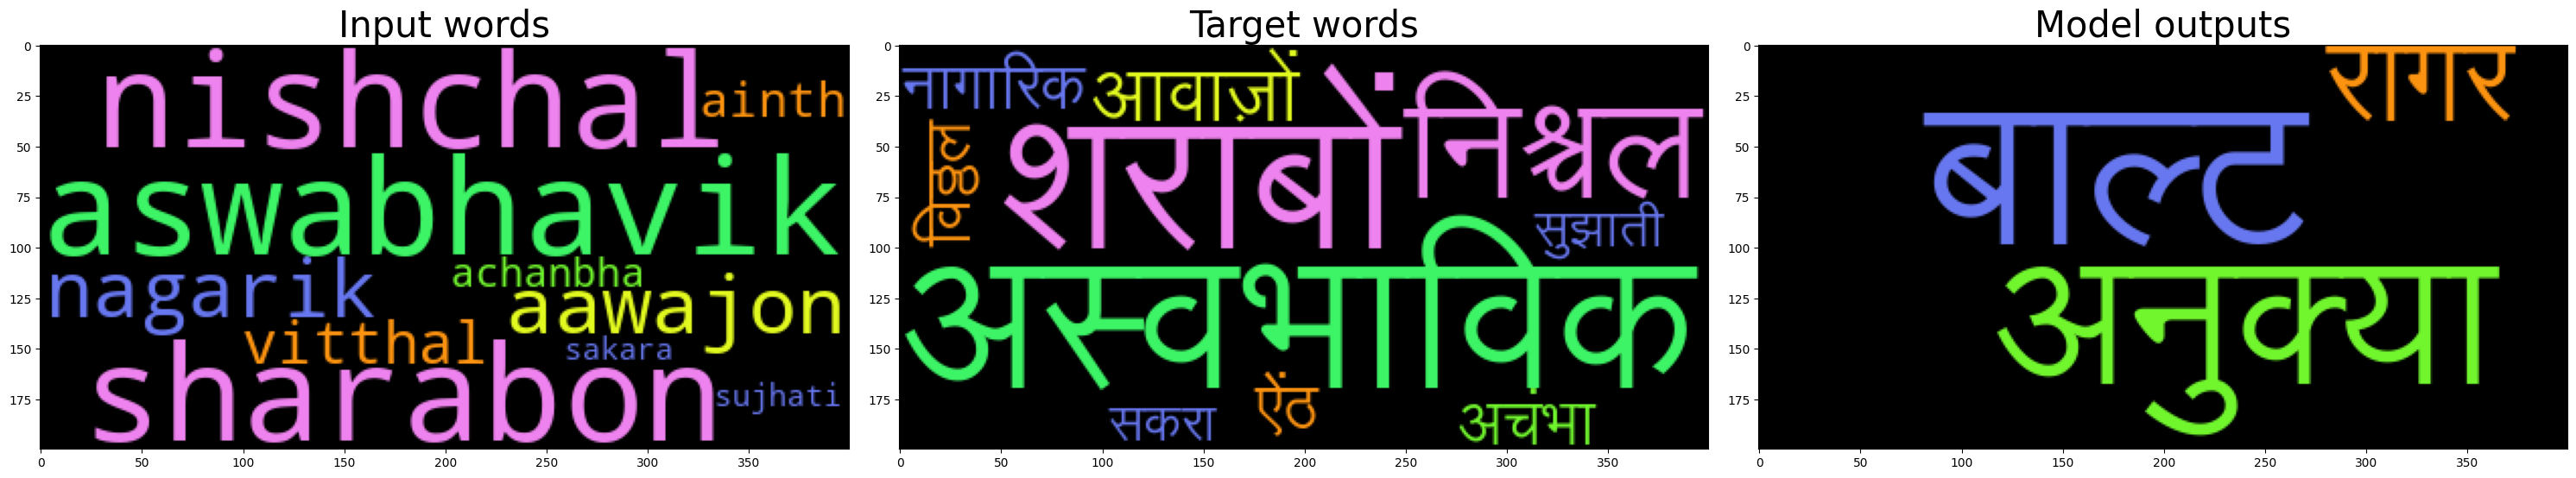

In [17]:
visualize_model_outputs(model, n=10)

In [52]:
def get_test_words(n):
    test_df = pd.read_csv(get_data_files("hi")[2])
    test_sample = test_df.sample(n)
    test_sample.reset_index(inplace=True, drop=True)
    test_words = []
    for i in test_sample.index:
        entry = test_sample["अंक\tank\t5"].loc[i]
        parts = entry.split("\t")
        word = parts[1]
        test_words.append(word)
    return test_words

test_words = get_test_words(5)
print(test_words)

['sure', 'trabal', 'lakir', 'parikalpit', 'krantiyon']


In [ ]:
for word in test_words:
    visualise_connectivity(model, word, activation="scaler")

In [ ]:
randomly_evaluate(model, n=20)

# WandB Function

In [10]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alokgaurav04 (alokgaurav04-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
def train_with_wandb(language, test_beam_search=False):

    config_defaults = {"embedding_dim": 64,
                       "enc_dec_layers": 1,
                       "layer_type": "lstm",
                       "units": 128,
                       "dropout": 0,
                       "attention": False,
                       "beam_width": 3,
                       "teacher_forcing_ratio": 1.0
                       }

    wandb.init(config=config_defaults, project="cs6910-assignment3", resume=True)
    # Below is an example of a custom run name for sweep 4
    # This line was different for all sweeps
    #wandb.run.name = f"beam_width_{wandb.config.beam_width}"

    ## 1. SELECT LANGUAGE ##
    TRAIN_TSV, VAL_TSV, TEST_TSV = get_data_files(language)

    ## 2. DATA PREPROCESSING ##
    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)

    ## 3. CREATING THE MODEL ##
    model = Seq2SeqModel(embedding_dim=wandb.config.embedding_dim,
                         encoder_layers=wandb.config.enc_dec_layers,
                         decoder_layers=wandb.config.enc_dec_layers,
                         layer_type=wandb.config.layer_type,
                         units=wandb.config.units,
                         dropout=wandb.config.dropout,
                         attention=wandb.config.attention)

    ## 4. COMPILING THE MODEL
    model.set_vocabulary(input_tokenizer, targ_tokenizer)
    model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metric = tf.keras.metrics.SparseCategoricalAccuracy())

    ## 5. FITTING AND VALIDATING THE MODEL
    model.fit(dataset, val_dataset, epochs=10, use_wandb=True, teacher_forcing_ratio=wandb.config.teacher_forcing_ratio)

    if test_beam_search:
        ## OPTIONAL :- Evaluate the dataset using beam search and without beam search
        val_dataset, _, _ = preprocess_data(VAL_TSV, model.input_tokenizer, model.targ_tokenizer)
        subset = val_dataset.take(500)

        # a) Without beam search
        _, test_acc_without = model.evaluate(subset, batch_size=100)
        wandb.log({"test acc": test_acc_without})

        # b) With beam search
        beam_search = BeamSearch(model=model, k=wandb.config.beam_width)
        beam_search.evaluate(subset, batch_size=100, use_wandb=True)

# Sweeps without Attention

In [12]:
sweep_config = {
  "name": "Sweep 1- Assignment3",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [64, 128, 256]
        },
        "layer_type": {
            "values": ["rnn", "gru", "lstm"]
        }
    }
}

In [13]:
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_3")

Create sweep with ID: dkm62s81
Sweep URL: https://wandb.ai/alokgaurav04-indian-institute-of-technology-madras/DA6401_Assignment_3/sweeps/dkm62s81


In [14]:
wandb.agent(sweep_id, function=lambda: train_with_wandb("hi"))

wandb: Agent Starting Run: nl3x59ir with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: rnn
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'simple_rnn_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'simple_rnn_1/while:4' shape=(128, 64) dtype=float32>)
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 64) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 64) dtype=float32>)
Batch 1 Loss 3.9041

Validating ...
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 64) dtype=float32>)

Train Loss: 2.2036 Train Accuracy: 46.8784 Validation Loss: 1.9055 Validation Accuracy: 56.1406

Time taken for the epoch 17.8355
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.5876

Validating ...

Train Loss: 1.4883 Train Accuracy: 61.5505 Validation Loss: 1.7534 Validation Accuracy: 58.2970

Time taken for the epoch 2.0319
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 L

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▆▆▇▇▇███
train loss,█▄▃▃▂▂▂▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▂▅▅▄▁█▇▇▅▇
val loss,█▄▁▁▆▁▂▂▆▄
epoch,10
train acc,71.24205
train loss,1.01857
training time,1.14035
val acc,60.20026


wandb: Agent Starting Run: w3x3eabm with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: rnn
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'simple_rnn_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'simple_rnn_1/while:4' shape=(128, 128) dtype=float32>)
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 128) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 128) dtype=float32>)
Batch 1 Loss 3.9512

Validating ...
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 128) dtype=float32>)

Train Loss: 1.9067 Train Accuracy: 48.2327 Validation Loss: 1.5673 Validation Accuracy: 58.6597

Time taken for the epoch 19.9233
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.4433

Validating ...

Train Loss: 1.3615 Train Accuracy: 63.3562 Validation Loss: 1.7050 Validation Accuracy: 56.9766

Time taken for the epoch 2.5908
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▅▆▆▇▇███
train loss,█▄▄▃▃▂▂▁▁▁
training time,█▁▁▁▂▁▁▁▁▂
val acc,▃▁▄▄▅▄▆▆█▇
val loss,▂█▁▄▂▆▄▇▅█
epoch,10
train acc,74.22447
train loss,0.89569
training time,3.92072
val acc,63.23509


wandb: Agent Starting Run: fr9qon39 with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: rnn
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'simple_rnn_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'simple_rnn_1/while:4' shape=(128, 256) dtype=float32>)
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 256) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 256) dtype=float32>)
Batch 1 Loss 3.9437

Validating ...
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 256) dtype=float32>)

Train Loss: 1.7635 Train Accuracy: 48.8646 Validation Loss: 1.6546 Validation Accuracy: 58.0913

Time taken for the epoch 21.6603
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.3254

Validating ...

Train Loss: 1.3234 Train Accuracy: 64.0789 Validation Loss: 1.6060 Validation Accuracy: 59.1211

Time taken for the epoch 6.5395
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▅▆▆▇▇███
train loss,█▅▄▄▃▂▂▂▁▁
training time,█▂▂▂▁▁▂▁▁▂
val acc,▁▂▃▃▆▆▅▇█▇
val loss,█▄██▃▁█▁▁▃
epoch,10
train acc,77.76102
train loss,0.75135
training time,6.97775
val acc,66.21439


wandb: Agent Starting Run: 2vfm8hm9 with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: gru
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'gru_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'gru_1/while:4' shape=(128, 64) dtype=float32>)
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 64) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 64) dtype=float32>)
Batch 1 Loss 3.8800

Validating ...
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 64) dtype=float32>)

Train Loss: 2.3279 Train Accuracy: 53.2743 Validation Loss: 2.2703 Validation Accuracy: 54.9836

Time taken for the epoch 27.2253
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.6472

Validating ...

Train Loss: 1.5297 Train Accuracy: 57.1868 Validation Loss: 1.9636 Validation Accuracy: 55.7688

Time taken for the epoch 4.0035
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.4280

Validating ...



epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▆▆▇▇▇███
train loss,█▃▃▂▂▂▁▁▁▁
training time,█▁▂▁▁▂▁▁▁▂
val acc,▁▃▇█▅█▆▂▁▂
val loss,█▄▄▃▂▁▁▃▃▃
epoch,10
train acc,67.17838
train loss,1.13217
training time,6.15334
val acc,55.30229


wandb: Agent Starting Run: 1olo4fyb with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: gru
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'gru_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'gru_1/while:4' shape=(128, 128) dtype=float32>)
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 128) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 128) dtype=float32>)
Batch 1 Loss 3.8810

Validating ...
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 128) dtype=float32>)

Train Loss: 2.1836 Train Accuracy: 51.5932 Validation Loss: 2.3308 Validation Accuracy: 54.9855

Time taken for the epoch 35.1601
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.5541

Validating ...

Train Loss: 1.4354 Train Accuracy: 62.0422 Validation Loss: 2.1179 Validation Accuracy: 56.7731

Time taken for the epoch 8.4901
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.3750

Validating .

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▆▆▇▇▇▇███
train loss,█▃▃▂▂▂▁▁▁▁
training time,█▂▁▂▁▁▁▁▂▁
val acc,▇██▄▁▅▅▆▄▆
val loss,▅▂▁▃█▂▂▁▄▁
epoch,10
train acc,66.95855
train loss,1.12586
training time,5.85797
val acc,54.20927


wandb: Agent Starting Run: t1lppv47 with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: gru
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'gru_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'gru_1/while:4' shape=(128, 256) dtype=float32>)
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 256) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 256) dtype=float32>)
Batch 1 Loss 3.9029

Validating ...
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 256) dtype=float32>)

Train Loss: 2.1030 Train Accuracy: 47.7395 Validation Loss: 2.4350 Validation Accuracy: 55.2542

Time taken for the epoch 40.0786
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.4977

Validating ...

Train Loss: 1.4269 Train Accuracy: 62.2349 Validation Loss: 2.2419 Validation Accuracy: 56.6204

Time taken for the epoch 13.8176
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.4214

Validating 

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▆▆▇▇▇████
train loss,█▃▃▂▂▁▁▁▁▁
training time,█▁▂▁▁▁▁▁▁▁
val acc,▅▇▆█▁▅▅▅▁▃
val loss,█▆▃▁▅▃▃▄▇▆
epoch,10
train acc,67.26767
train loss,1.10884
training time,14.39901
val acc,53.07937


wandb: Agent Starting Run: hk1nf58r with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: lstm
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'lstm_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'lstm_1/while:4' shape=(128, 64) dtype=float32>, <tf.Tensor 'lstm_1/while:5' shape=(128, 64) dtype=float32>)
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 64) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 64) dtype=float32>)
Batch 1 Loss 3.8955

Validating ...
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 64) dtype=float32>)

Train Loss: 2.4187 Train Accuracy: 47.2186 Validation Loss: 1.9003 Validation Accuracy: 54.4644

Time taken for the epoch 25.3045
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.6859

Validating ...

Train Loss: 1.5600 Train Accuracy: 57.6805 Validation Loss: 2.0084 Validation Accuracy: 54.8533

Time taken for the epoch 4.8641
---------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▇▇▇▇▇███
train loss,█▃▂▂▂▂▂▁▁▁
training time,█▂▁▁▁▂▁▁▁▂
val acc,▄▅▆▆▇██▆▁▄
val loss,▅▇▅█▆▂▁▁▄▂
epoch,10
train acc,65.97175
train loss,1.19611
training time,5.89188
val acc,54.74354


wandb: Agent Starting Run: euf128x8 with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: lstm
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'lstm_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'lstm_1/while:4' shape=(128, 128) dtype=float32>, <tf.Tensor 'lstm_1/while:5' shape=(128, 128) dtype=float32>)
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 128) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 128) dtype=float32>)
Batch 1 Loss 3.8965

Validating ...
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 128) dtype=float32>)

Train Loss: 2.1595 Train Accuracy: 48.0752 Validation Loss: 1.9355 Validation Accuracy: 55.1193

Time taken for the epoch 30.3869
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.5481

Validating ...

Train Loss: 1.4577 Train Accuracy: 61.3291 Validation Loss: 2.0916 Validation Accuracy: 56.0738

Time taken for the epoch 8.3336
---------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▆▆▇▇▇▇███
train loss,█▃▃▃▂▂▁▁▁▁
training time,█▂▁▂▁▁▁▁▂▁
val acc,▁▃▃▅▅▇█▃▃▆
val loss,▄▆▇█▆▄▁▃▂▂
epoch,10
train acc,66.3863
train loss,1.1542
training time,5.84927
val acc,57.81095


wandb: Agent Starting Run: 2efn4sh6 with config:
wandb: 	enc_dec_layers: 1
wandb: 	layer_type: lstm
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'lstm_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'lstm_1/while:4' shape=(128, 256) dtype=float32>, <tf.Tensor 'lstm_1/while:5' shape=(128, 256) dtype=float32>)
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 256) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 256) dtype=float32>)
Batch 1 Loss 3.8921

Validating ...
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 256) dtype=float32>)

Train Loss: 1.9741 Train Accuracy: 48.9304 Validation Loss: 1.8302 Validation Accuracy: 56.3014

Time taken for the epoch 40.6598
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.5731

Validating ...

Train Loss: 1.4290 Train Accuracy: 61.7017 Validation Loss: 2.1929 Validation Accuracy: 56.4938

Time taken for the epoch 16.5311
--------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▆▆▇▇▇████
train loss,█▄▃▃▂▂▂▁▁▁
training time,█▁▁▁▁▁▁▁▂▁
val acc,▄▅▅███▆▃█▁
val loss,▁▇█▂▃▂▂▃▁▄
epoch,10
train acc,66.6647
train loss,1.12385
training time,16.17542
val acc,54.90662


wandb: Agent Starting Run: j9ebx8z4 with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: rnn
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'simple_rnn_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'simple_rnn_1/while:4' shape=(128, 64) dtype=float32>)
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 64) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 64) dtype=float32>)
Batch 1 Loss 3.9253

Validating ...
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 64) dtype=float32>)

Train Loss: 2.2403 Train Accuracy: 41.3821 Validation Loss: 2.0613 Validation Accuracy: 55.9530

Time taken for the epoch 32.9874
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.4938

Validating ...

Train Loss: 1.4209 Train Accuracy: 62.9113 Validation Loss: 1.7602 Validation Accuracy: 57.5141

Time taken for the epoch 1.8447
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 L

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▆▆▇▇▇████
train loss,█▃▃▂▂▂▂▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▂▆▆▇▇█▇█▇
val loss,█▄▂▂▁▁▁▁▁▂
epoch,10
train acc,72.37135
train loss,0.97432
training time,1.91343
val acc,62.34296


wandb: Agent Starting Run: 26clfyy7 with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: rnn
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'simple_rnn_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'simple_rnn_1/while:4' shape=(128, 128) dtype=float32>)
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 128) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 128) dtype=float32>)
Batch 1 Loss 3.9506

Validating ...
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 128) dtype=float32>)

Train Loss: 1.9902 Train Accuracy: 42.8718 Validation Loss: 1.7358 Validation Accuracy: 58.3556

Time taken for the epoch 36.0581
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.3956

Validating ...

Train Loss: 1.3541 Train Accuracy: 63.4817 Validation Loss: 1.6923 Validation Accuracy: 60.2011

Time taken for the epoch 6.5728
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▆▆▇▇▇███
train loss,█▄▄▃▃▂▂▂▁▁
training time,█▁▁▂▁▁▁▁▁▁
val acc,▂▄▁▆▅▇██▇█
val loss,▄▃█▂▂▂▁▁▃▂
epoch,10
train acc,76.34332
train loss,0.81102
training time,6.41018
val acc,65.9294


wandb: Agent Starting Run: 7sovn1gl with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: rnn
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'simple_rnn_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'simple_rnn_1/while:4' shape=(128, 256) dtype=float32>)
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 256) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 256) dtype=float32>)
Batch 1 Loss 3.9129

Validating ...
LSTM layer: rnn
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/simple_rnn_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/simple_rnn_1/while:4' shape=(128, 256) dtype=float32>)

Train Loss: 1.7747 Train Accuracy: 48.3166 Validation Loss: 2.0544 Validation Accuracy: 57.3567

Time taken for the epoch 41.9818
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.4018

Validating ...

Train Loss: 1.3664 Train Accuracy: 62.8916 Validation Loss: 2.3302 Validation Accuracy: 57.4593

Time taken for the epoch 11.3545
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batc

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▆▆▇▇▇███
train loss,█▅▄▃▂▂▂▂▁▁
training time,█▂▁▂▂▁▁▂▁▁
val acc,▁▁▃▄▅▆▅▆▇█
val loss,▄█▃▄▂▂▅▂▁▁
epoch,10
train acc,71.40603
train loss,0.95575
training time,9.86299
val acc,62.60539


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g3todfhn with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: gru
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'gru_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'gru_1/while:4' shape=(128, 64) dtype=float32>)
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 64) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 64) dtype=float32>)
Batch 1 Loss 3.8977

Validating ...
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 64) dtype=float32>)

Train Loss: 2.7754 Train Accuracy: 47.8017 Validation Loss: 2.5808 Validation Accuracy: 54.0169

Time taken for the epoch 51.9499
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.8145

Validating ...

Train Loss: 1.6914 Train Accuracy: 54.5965 Validation Loss: 2.8134 Validation Accuracy: 53.9573

Time taken for the epoch 6.3347
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.5640

Validating ...



epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▄▄▆▇▇▇▇██
train loss,█▃▃▂▂▂▁▁▁▁
training time,█▁▁▁▁▁▂▂▁▁
val acc,▁▁▃▄▆▇▇▇▄█
val loss,▆█▅▄▁▂▁▁▂▁
epoch,10
train acc,66.46117
train loss,1.16497
training time,8.9067
val acc,58.71024


wandb: Agent Starting Run: uc2phuo9 with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: gru
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'gru_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'gru_1/while:4' shape=(128, 128) dtype=float32>)
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 128) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 128) dtype=float32>)
Batch 1 Loss 3.9003

Validating ...
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 128) dtype=float32>)

Train Loss: 2.5056 Train Accuracy: 47.5796 Validation Loss: 2.5071 Validation Accuracy: 55.5003

Time taken for the epoch 57.3612
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.7697

Validating ...

Train Loss: 1.6173 Train Accuracy: 55.5910 Validation Loss: 2.4259 Validation Accuracy: 55.8505

Time taken for the epoch 13.9120
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.3766

Validating 

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▄▆▆▆▆▇▇▇█
train loss,█▄▂▂▂▂▂▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▁▃▂▃▃▄▆▇█
val loss,█▇▃▁▆▇▇▅▅▃
epoch,10
train acc,69.26122
train loss,1.08557
training time,14.03503
val acc,61.80873


wandb: Agent Starting Run: pj1ah05j with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: gru
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'gru_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'gru_1/while:4' shape=(128, 256) dtype=float32>)
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 256) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 256) dtype=float32>)
Batch 1 Loss 3.8982

Validating ...
LSTM layer: gru
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/gru_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/gru_1/while:4' shape=(128, 256) dtype=float32>)

Train Loss: 2.2049 Train Accuracy: 47.7918 Validation Loss: 3.8962 Validation Accuracy: 54.8092

Time taken for the epoch 78.0654
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.6418

Validating ...

Train Loss: 1.4652 Train Accuracy: 57.2378 Validation Loss: 2.2448 Validation Accuracy: 57.4065

Time taken for the epoch 32.5874
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.3545

Validating 

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▅▇▇▇▇████
train loss,█▃▂▂▂▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▆▆▅▇▇▇█▅▅
val loss,█▁▂▃▃▄▂▂▁▁
epoch,10
train acc,65.92496
train loss,1.14606
training time,29.54335
val acc,56.58003


wandb: Agent Starting Run: zvwgo4wg with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: lstm
wandb: 	units: 64


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'lstm_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'lstm_1/while:4' shape=(128, 64) dtype=float32>, <tf.Tensor 'lstm_1/while:5' shape=(128, 64) dtype=float32>)
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 64) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 64) dtype=float32>)
Batch 1 Loss 3.8982

Validating ...
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 64) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 64) dtype=float32>)

Train Loss: 3.2187 Train Accuracy: 47.6027 Validation Loss: 2.4828 Validation Accuracy: 53.4755

Time taken for the epoch 49.6580
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.9087

Validating ...

Train Loss: 1.7958 Train Accuracy: 54.2504 Validation Loss: 2.8479 Validation Accuracy: 54.2233

Time taken for the epoch 8.6521
---------------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▄▄▆▇▇▇███
train loss,█▃▂▂▂▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▂▂▂▄▆▇▆██
val loss,▅█▆▆▅▂▂▁▂▁
epoch,10
train acc,64.22071
train loss,1.25574
training time,7.60856
val acc,58.12186


wandb: Agent Starting Run: 2waabsqm with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: lstm
wandb: 	units: 128


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'lstm_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'lstm_1/while:4' shape=(128, 128) dtype=float32>, <tf.Tensor 'lstm_1/while:5' shape=(128, 128) dtype=float32>)
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 128) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 128) dtype=float32>)
Batch 1 Loss 3.8989

Validating ...
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 128) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 128) dtype=float32>)

Train Loss: 2.8165 Train Accuracy: 47.7587 Validation Loss: 2.6407 Validation Accuracy: 54.1436

Time taken for the epoch 55.6425
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.8099

Validating ...

Train Loss: 1.7150 Train Accuracy: 54.2346 Validation Loss: 2.9298 Validation Accuracy: 54.9934

Time taken for the epoch 13.1320
--------

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▄▄▇▇▇████
train loss,█▃▂▂▂▁▁▁▁▁
training time,█▁▁▁▁▁▁▁▁▁
val acc,▁▃▁▃▇▇███▇
val loss,▅██▆▁▂▃▃▄▄
epoch,10
train acc,63.81169
train loss,1.252
training time,12.05309
val acc,57.04591


wandb: Agent Starting Run: aqql3yo0 with config:
wandb: 	enc_dec_layers: 2
wandb: 	layer_type: lstm
wandb: 	units: 256


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'lstm_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'lstm_1/while:4' shape=(128, 256) dtype=float32>, <tf.Tensor 'lstm_1/while:5' shape=(128, 256) dtype=float32>)
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 256) dtype=float32>)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator/seed_generator_state', 'seed_generator_1/seed_generator_state', 'seed_generator_2/seed_generator_state', 'seed_generator_3/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 256) dtype=float32>)
Batch 1 Loss 3.8990

Validating ...
LSTM layer: lstm
Returned: <class 'tuple'> (<tf.Tensor 'encoder_1/lstm_1/transpose_1:0' shape=(128, 20, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:4' shape=(128, 256) dtype=float32>, <tf.Tensor 'encoder_1/lstm_1/while:5' shape=(128, 256) dtype=float32>)

Train Loss: 2.5282 Train Accuracy: 47.8397 Validation Loss: 2.6046 Validation Accuracy: 55.2699

Time taken for the epoch 74.7656
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.7518

Validating ...

Train Loss: 1.6155 Train Accuracy: 54.9346 Validation Loss: 2.8605 Validation Accuracy: 55.0234

Time taken for the epoch 35.4477
--------

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
sweep_config2 = {
  "name": "Sweep 2- Assignment3",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [2, 3]
        },
        "embedding_dim": {
            "values": [64, 128, 256]
        },
        "dropout": {
            "values": [0.2, 0.3]
        }
    }
}

In [ ]:
sweep_id2 = wandb.sweep(sweep_config2, project="cs6910-assignment3")

Create sweep with ID: 5albgxrx
Sweep URL: https://wandb.ai/avyay-sujay/cs6910-assignment3/sweeps/5albgxrx


In [ ]:
wandb.agent(sweep_id2, function=lambda: train_with_wandb("hi"))

400 response executing GraphQL.
{"errors":[{"message":"Sweep avyay-sujay/cs6910-assignment3/j34ugi2z is not running","path":["createAgent"]}],"data":{"createAgent":null}}
wandb: ERROR Error while calling W&B API: Sweep avyay-sujay/cs6910-assignment3/j34ugi2z is not running (<Response [400]>)


CommError: ignored

In [ ]:
sweep_config3 = {
  "name": "Sweep 3- Assignment3",
  "method": "grid",
  "parameters": {

        "beam_width": {
            "values": [3, 5, 7]
        }
    }
}

In [ ]:
sweep_id3 = wandb.sweep(sweep_config3, project="cs6910-assignment3")

Create sweep with ID: 4zlxmroc
Sweep URL: https://wandb.ai/avyay-sujay/cs6910-assignment3/sweeps/4zlxmroc


In [ ]:
wandb.agent(sweep_id3, function=lambda: train_with_wandb("hi", test_beam_search=True))

wandb: Agent Starting Run: 0pufvyyg with config:
wandb: 	beam_width: 3
wandb: Currently logged in as: avyay-sujay (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 4.0016
Batch 100 Loss 1.2018
Batch 200 Loss 1.0734
Batch 300 Loss 1.0325

Validating ...

Train Loss: 1.2420 Train Accuracy: 65.0423 Validation Loss: 2.2113 Validation Accuracy: 57.2605

Time taken for the epoch 45.7425
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.0593
Batch 100 Loss 0.9826
Batch 200 Loss 0.9905
Batch 300 Loss 0.9409

Validating ...

Train Loss: 0.9783 Train Accuracy: 71.8663 Validation Loss: 2.4676 Validation Accuracy: 48.8581

Time taken for the epoch 13.5449
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9398
Batch 100 Loss 0.9202
Batch 200 Loss 0.9051
Batch 300 Loss 0.8446

Validating ...

Train Loss: 0.8938 Train Accuracy: 73.6818 Validation Loss:

epoch,30
train loss,0.11374
val loss,1.52534
train acc,96.32546
val acc,80.6057
training time,13.16627
_runtime,1786
_timestamp,1620366083
_step,31
test acc,0.80037
test acc (beam search),0.82467


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,▆█▇▆▇▅▄▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂
train acc,▁▃▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████████
val acc,▃▁▂▂▂▃▄▅▆▆▇▇▇▇▇▇▇▇████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃█
_timestamp,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
test acc,▁
test acc (beam search),▁


wandb: Agent Starting Run: qffoi3wc with config:
wandb: 	beam_width: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9961
Batch 100 Loss 1.2004
Batch 200 Loss 1.1648
Batch 300 Loss 0.9915

Validating ...

Train Loss: 1.2269 Train Accuracy: 66.0237 Validation Loss: 2.1906 Validation Accuracy: 57.6330

Time taken for the epoch 44.0926
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9852
Batch 100 Loss 0.9227
Batch 200 Loss 0.9793
Batch 300 Loss 0.9290

Validating ...

Train Loss: 0.9703 Train Accuracy: 72.2165 Validation Loss: 1.9718 Validation Accuracy: 57.1931

Time taken for the epoch 12.7838
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9196
Batch 100 Loss 0.9020
Batch 200 Loss 0.8746
Batch 300 Loss 0.9009

Validating ...

Train Loss: 0.8904 Train Accuracy: 74.1487 Validation Loss:

epoch,30
train loss,0.11646
val loss,1.51322
train acc,96.2393
val acc,80.96451
training time,12.36579
_runtime,2828
_timestamp,1620368919
_step,31
test acc,0.80597
test acc (beam search),0.83813


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▆▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▆▇▇▇▅▄▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂
train acc,▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇█████████████
val acc,▂▂▁▁▂▃▄▅▆▆▆▇▇▇▇▇▇▇████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
test acc,▁
test acc (beam search),▁


wandb: Agent Starting Run: a1ftyvj0 with config:
wandb: 	beam_width: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9953
Batch 100 Loss 1.2809
Batch 200 Loss 1.0752
Batch 300 Loss 1.0601

Validating ...

Train Loss: 1.2383 Train Accuracy: 65.9303 Validation Loss: 2.2258 Validation Accuracy: 57.1164

Time taken for the epoch 44.1009
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 0.9911
Batch 100 Loss 0.9297
Batch 200 Loss 0.9719
Batch 300 Loss 0.9168

Validating ...

Train Loss: 0.9682 Train Accuracy: 72.0878 Validation Loss: 1.9808 Validation Accuracy: 55.6142

Time taken for the epoch 12.6151
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 0.9411
Batch 100 Loss 0.9003
Batch 200 Loss 0.8293
Batch 300 Loss 0.8576

Validating ...

Train Loss: 0.8831 Train Accuracy: 74.3905 Validation Loss:

epoch,30
train loss,0.11349
val loss,1.53597
train acc,96.39883
val acc,81.78071
training time,12.58215
_runtime,3914
_timestamp,1620372841
_step,31
test acc,0.80927
test acc (beam search),0.85493


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▆▆▅▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▆▇▇▇▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
train acc,▁▂▃▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇████████████
val acc,▂▁▁▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇▇███████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂█
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂█
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
test acc,▁
test acc (beam search),▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
sweep_config4 = {
  "name": "Sweep 4- Assignment3",
  "method": "grid",
  "parameters": {
        "teacher_forcing_ratio": {
            "values": [0.3, 0.5, 0.7, 0.9]
        },
        "enc_dec_layers": {
            "values": [2]
        },
        "embedding_dim": {
            "values": [128]
        },
        "dropout": {
            "values": [0.2]
        }
    }
}

In [ ]:
sweep_id4 = wandb.sweep(sweep_config4, project="cs6910-assignment3")

Create sweep with ID: 5icmpzq8
Sweep URL: https://wandb.ai/avyay-sujay/cs6910-assignment3/sweeps/5icmpzq8


In [ ]:
wandb.agent(sweep_id4, function=lambda: train_with_wandb("hi"))

wandb: Agent Starting Run: 8ybexhh8 with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	teacher_forcing_ratio: 0.3
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Tried to auto resume run with id 62nlwdk7 but id 8ybexhh8 is set.


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9904
Batch 100 Loss 1.3826
Batch 200 Loss 1.1709
Batch 300 Loss 1.1460

Validating ...
Batch 100 Loss 1.1514
Batch 200 Loss 1.1215
Batch 300 Loss 1.0854

Validating ...

Train Loss: 1.1034 Train Accuracy: 68.8291 Validation Loss: 1.3702 Validation Accuracy: 60.6189

Time taken for the epoch 18.1498
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0623
Batch 100 Loss 1.0360
Batch 200 Loss 0.9609
Batch 300 Loss 1.0318

Validating ...

Train Loss: 1.0369 Train Accuracy: 69.8613 Validation Loss: 1.2249 Validation Accuracy: 63.4101

Time taken for the epoch 19.1298
----------------------------------------------------------------------------------------------------
EPOCH 4

Training ...

Batch 1 Loss 0.9600
Batch 100 Loss 0.9282
Batch 200 Loss 0.8459
Batch 300 Loss 0

epoch,30
train loss,0.17751
val loss,0.56964
train acc,94.27013
val acc,82.78063
training time,19.42183
_runtime,639
_timestamp,1621435505
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▇▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val loss,██▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train acc,▁▂▂▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val acc,▁▁▂▃▅▅▆▇▇▇▇▇▇▇████████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: u82ajo4r with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	teacher_forcing_ratio: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9825
Batch 100 Loss 1.2470
Batch 200 Loss 1.1471
Batch 300 Loss 1.1070

Validating ...

Train Loss: 1.2955 Train Accuracy: 64.5183 Validation Loss: 1.3983 Validation Accuracy: 59.9727

Time taken for the epoch 75.6178
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1263
Batch 100 Loss 1.0504
Batch 200 Loss 1.0697
Batch 300 Loss 1.0973

Validating ...

Train Loss: 1.0847 Train Accuracy: 69.1409 Validation Loss: 1.3273 Validation Accuracy: 61.1075

Time taken for the epoch 19.6557
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0912
Batch 100 Loss 0.9818
Batch 200 Loss 1.0120
Batch 300 Loss 0.9695

Validating ...

Train Loss: 1.0031 Train Accuracy: 70.6021 Validation Loss:

epoch,30
train loss,0.174
val loss,0.59118
train acc,94.40459
val acc,82.35094
training time,19.13791
_runtime,639
_timestamp,1621436153
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val loss,█▇▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
train acc,▁▂▂▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val acc,▁▁▂▄▅▆▆▇▇▇▇▇▇███▇█████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 5msssa2r with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	teacher_forcing_ratio: 0.7
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9878
Batch 100 Loss 1.3625
Batch 200 Loss 1.1897
Batch 300 Loss 1.1338

Validating ...

Train Loss: 1.3079 Train Accuracy: 64.2670 Validation Loss: 1.4565 Validation Accuracy: 58.9851

Time taken for the epoch 73.3697
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1578
Batch 100 Loss 1.0876
Batch 200 Loss 1.0454
Batch 300 Loss 1.0666

Validating ...

Train Loss: 1.0983 Train Accuracy: 68.9774 Validation Loss: 1.3552 Validation Accuracy: 61.0868

Time taken for the epoch 19.6721
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0002
Batch 100 Loss 0.9983
Batch 200 Loss 1.0425
Batch 300 Loss 0.9732

Validating ...

Train Loss: 1.0148 Train Accuracy: 70.2442 Validation Loss:

epoch,30
train loss,0.18027
val loss,0.58041
train acc,94.14017
val acc,82.41394
training time,19.02445
_runtime,636
_timestamp,1621436798
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val loss,█▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train acc,▁▂▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████████
val acc,▁▂▃▄▄▅▆▇▇▇▇▇▇█████████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: dkszoxhx with config:
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_dec_layers: 2
wandb: 	teacher_forcing_ratio: 0.9
wandb: WARNING Ignored wandb.init() arg project when running a sweep


----------------------------------------------------------------------------------------------------
EPOCH 1

Training ...

Batch 1 Loss 3.9921
Batch 100 Loss 1.3232
Batch 200 Loss 1.2982
Batch 300 Loss 1.1532

Validating ...

Train Loss: 1.3298 Train Accuracy: 63.6911 Validation Loss: 1.4065 Validation Accuracy: 60.1390

Time taken for the epoch 74.5291
----------------------------------------------------------------------------------------------------
EPOCH 2

Training ...

Batch 1 Loss 1.1367
Batch 100 Loss 1.1209
Batch 200 Loss 1.1088
Batch 300 Loss 1.1362

Validating ...

Train Loss: 1.1042 Train Accuracy: 68.8516 Validation Loss: 1.3575 Validation Accuracy: 61.0471

Time taken for the epoch 19.7109
----------------------------------------------------------------------------------------------------
EPOCH 3

Training ...

Batch 1 Loss 1.0830
Batch 100 Loss 1.0335
Batch 200 Loss 0.9891
Batch 300 Loss 0.9507

Validating ...

Train Loss: 1.0346 Train Accuracy: 70.1111 Validation Loss:

epoch,30
train loss,0.17065
val loss,0.57507
train acc,94.46995
val acc,83.02238
training time,19.81282
_runtime,662
_timestamp,1621437469
_step,29


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val loss,██▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train acc,▁▂▂▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████
val acc,▁▁▂▃▅▅▆▆▇▇▇▇▇▇█▇██████████████
training time,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Sweeps with Attention

In [ ]:
sweep_config5 = {
  "name": "Attention Sweep - Assignment3",
  "description": "Hyperparameter sweep for Seq2Seq Model with Attention",
  "method": "grid",
  "parameters": {
        "enc_dec_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [128, 256]
        },
        "dropout": {
            "values": [0, 0.2]
        },
        "attention": {
            "values": [True]
        }
    }
}

In [ ]:
sweep_id5 = wandb.sweep(sweep_config5, project="cs6910-assignment3")

Create sweep with ID: i02ay5ux
Sweep URL: https://wandb.ai/avyay/cs6910-assignment3/sweeps/i02ay5ux


In [ ]:
wandb.agent(sweep_id5, function=lambda: train_with_wandb("hi"), project="cs6910-assignment3")

400 response executing GraphQL.
{"errors":[{"message":"Sweep avyay/cs6910-assignment3/i02ay5ux is not running","path":["createAgent"]}],"data":{"createAgent":null}}
wandb: ERROR Error while calling W&B API: Sweep avyay/cs6910-assignment3/i02ay5ux is not running (<Response [400]>)


CommError: ignored